만들면서 뭔가 이상한 점이 느껴지지 않으셨나요? 프로젝트를 통해 찾아봅시다.

우선 주요 라이브러리 버전을 확인해 볼까요?

In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인
import os
from importlib.metadata import version
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pixellib
from pixellib.semantic import semantic_segmentation

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


Step 1. 인물모드 직접 해 보기
여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

(5256, 3504, 3)


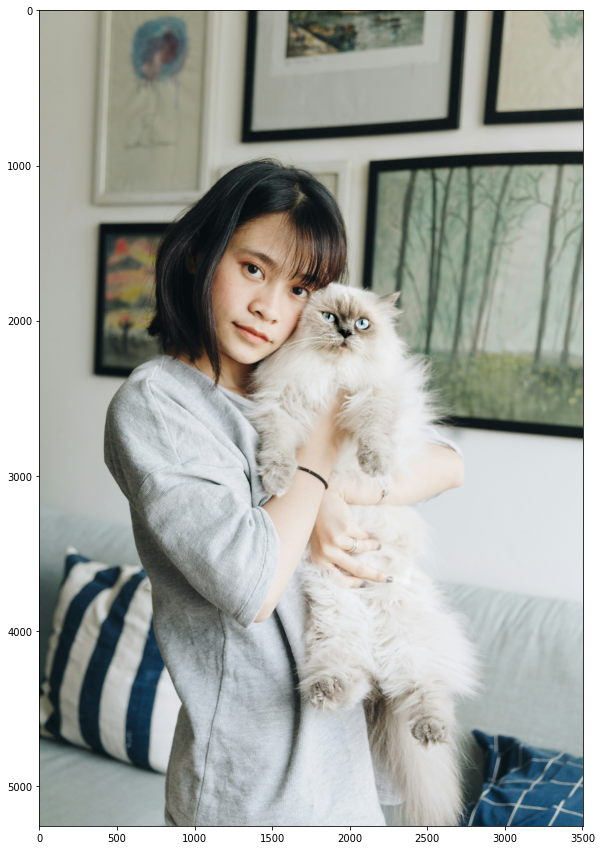

In [2]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/tran-mau-tri-tam-Fst4SmneRU4-unsplash.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)



# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.figure(figsize=(25, 15))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

시맨틱 세그멘테이션 모델 로드 및 사진 분석

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
# 시맨틱 세그멘테이션 모델 로드
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)


# 시맨틱 세그멘테이션 수행 (마스크 파일 저장)
segvalues, output = model.segmentAsPascalvoc(img_path) 

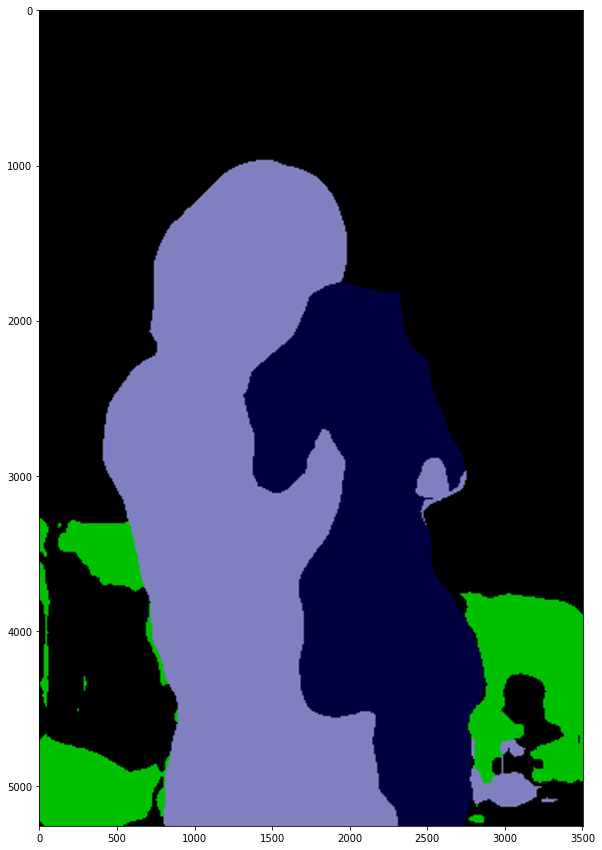

In [5]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.figure(figsize=(25, 15))
plt.imshow(output)
plt.show()

In [6]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [7]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0,  8, 15, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [8]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
person
sofa


In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[8] #컬러맵 8(고양이)에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 8번째인 고양이)

array([64,  0,  0])

In [12]:
seg_color = (0,0,64) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(5256, 3504)


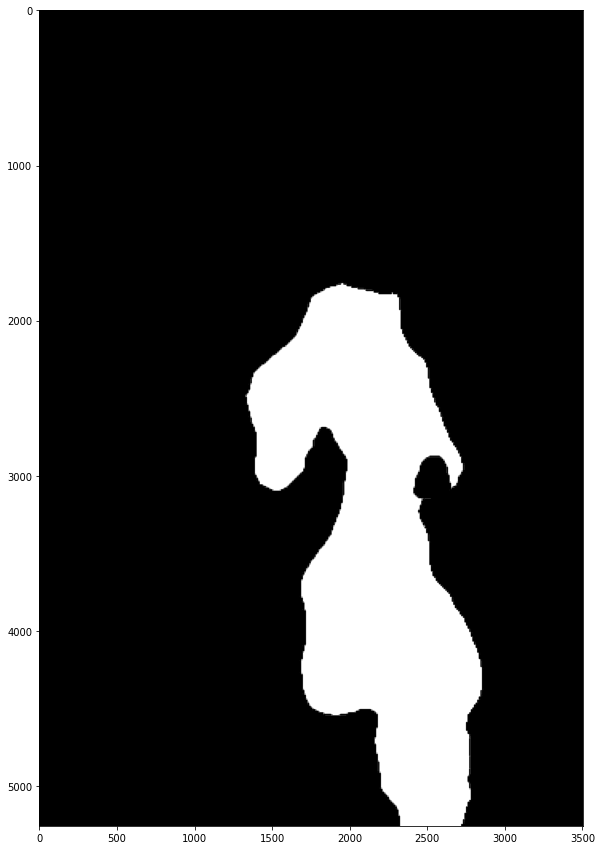

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 고야이 값이므로 고양이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.figure(figsize=(25, 15))
plt.imshow(seg_map, cmap='gray')
plt.show()

마스크 생성 및 아웃포커싱 적용

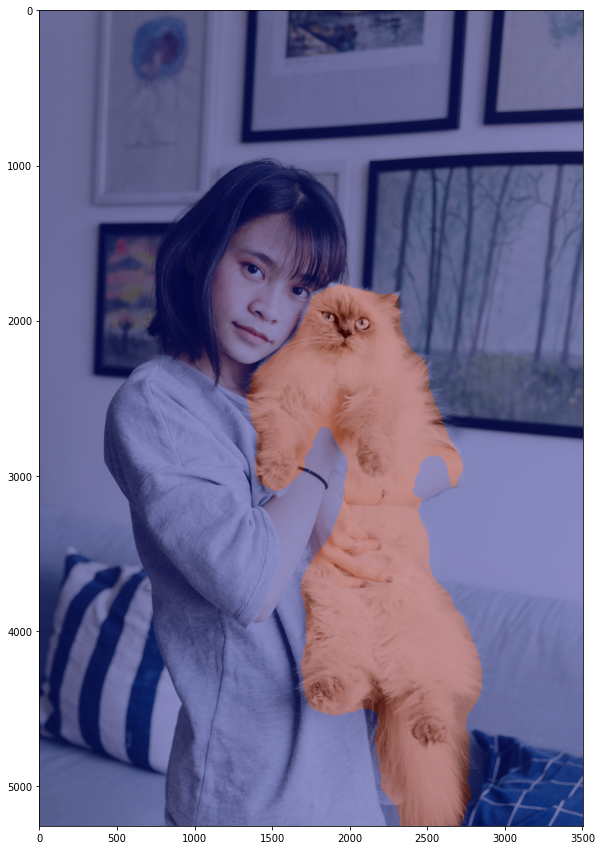

In [14]:
# 원본이미지를 img_show에 할당한뒤 이미지 고양이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(25, 15))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

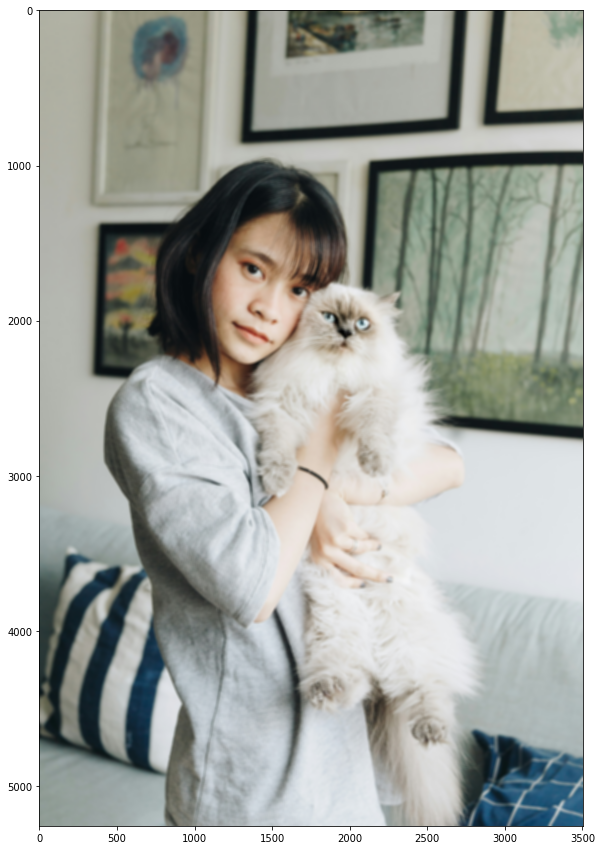

In [16]:
# (50,50)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (20,20))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.figure(figsize=(25, 15))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

Step 2. 사진에서 문제점 찾기
그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

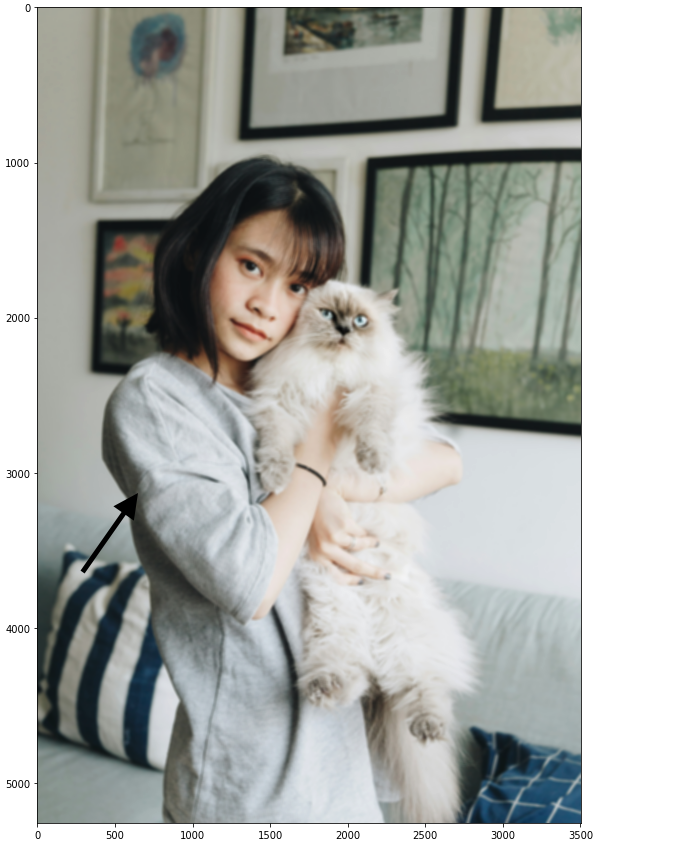

Step 3. 해결 방법을 제안해 보기
아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.